In [35]:
!pip install --upgrade xgboost

  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)


In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, log_loss
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier, plot_importance, XGBRegressor
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_sample_weight

In [5]:
train = pd.read_csv('trainFeaturesXGBoost.csv')
train['outage_occurred'] = (train['customers_out'] > 0).astype(int)

test = pd.read_csv('testFeaturesXGBoost.csv')
test['outage_occurred'] = (test['customers_out'] > 0).astype(int)

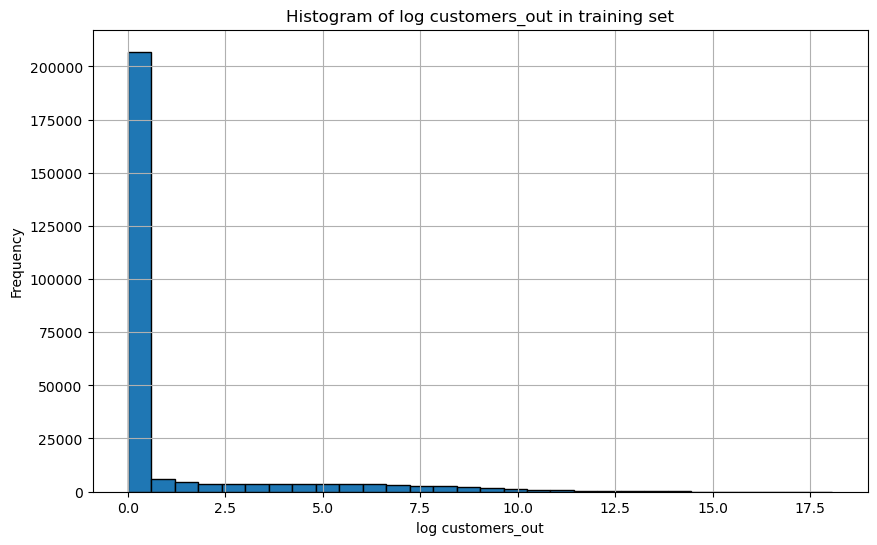

In [5]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(train['customers_out']), bins=30, edgecolor='black')
plt.title('Histogram of log customers_out in training set')
plt.xlabel('log customers_out')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:
print(train['outage_occurred'].value_counts())


outage_occurred
0    206948
1     54365
Name: count, dtype: int64


In [9]:
categorical_cols = ['event_type_num', 'begin_weekday', 'begin_month', 'FIPS']

y_train = train['outage_occurred']
X_train = train.drop(columns=['customers_out', 'outage_occurred'])

y_test = test['outage_occurred']
X_test = test.drop(columns=['customers_out', 'outage_occurred'])

# Set correct dtypes
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')

for col in categorical_cols:
    X_test[col] = X_test[col].astype('category')

In [ ]:

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]) #shift priority to recall


model = XGBClassifier(
    tree_method='hist',              # Required for categorical support
    enable_categorical=True,         # Enables native handling
    use_label_encoder=False,         # Avoids legacy warning
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print("Greater than 25:", (train['customers_out'] > 25).sum())
print("Less than or equal to 25:", (train['customers_out'] <= 25).sum())

c:\Users\jdsto\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:11:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.87      0.85      0.86     51758
           1       0.47      0.51      0.49     13570

    accuracy                           0.78     65328
   macro avg       0.67      0.68      0.68     65328
weighted avg       0.79      0.78      0.78     65328

Greater than 25: 34786
Less than or equal to 25: 226527


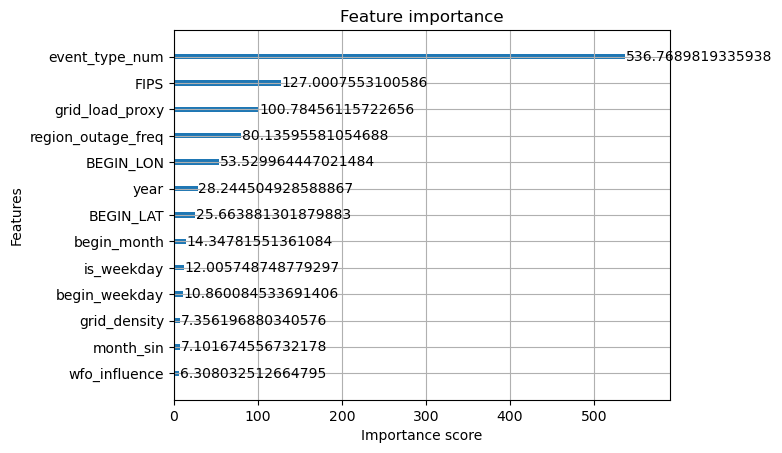

In [192]:
plot_importance(model, max_num_features=20, importance_type='gain')  # or 'weight', 'cover'
plt.show()

Binned Classification

Best threshold: 0.16 | Best F1: 0.688
              precision    recall  f1-score   support

         low       0.76      0.11      0.19      4883
        high       0.53      0.97      0.69      5165

    accuracy                           0.55     10048
   macro avg       0.65      0.54      0.44     10048
weighted avg       0.64      0.55      0.45     10048



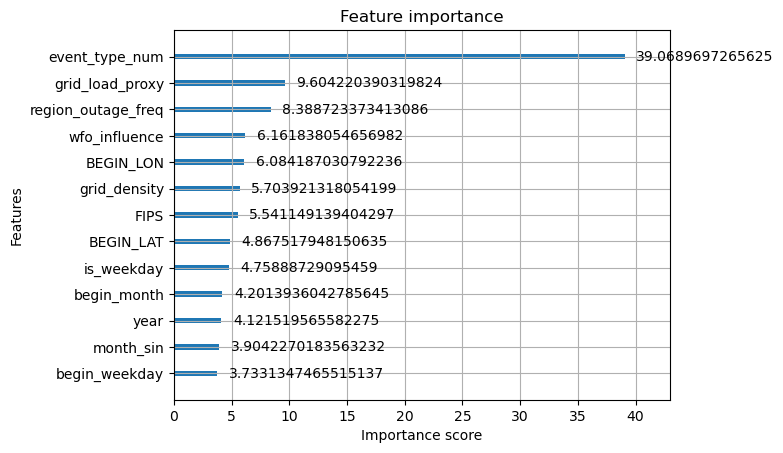

In [193]:
# Step 1: Bucket into 'low' and 'high'

def bucket_outage_binary(x):
    return 'low' if x <= 25 else 'high'

train_out = train[(train['outage_occurred'] == 1) & (train['customers_out'] <= 1000)].copy()
test_out = test[(test['outage_occurred'] == 1) & (test['customers_out'] <= 1000)].copy()

train_out['outage_bucket'] = train_out['customers_out'].apply(bucket_outage_binary)
test_out['outage_bucket'] = test_out['customers_out'].apply(bucket_outage_binary)

label_map = {'low': 0, 'high': 1}
train_out['bucket_label'] = train_out['outage_bucket'].map(label_map)
test_out['bucket_label'] = test_out['outage_bucket'].map(label_map)

X_train = train_out.drop(columns=['customers_out', 'outage_occurred', 'outage_bucket', 'bucket_label'])
y_train = train_out['bucket_label']

X_test = test_out.drop(columns=['customers_out', 'outage_occurred', 'outage_bucket', 'bucket_label'])
y_test = test_out['bucket_label']

# Compute balanced sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Train the classifier
model = XGBClassifier(
    tree_method='hist',
    enable_categorical=True,
    random_state=42
)

model.fit(X_train, y_train, sample_weight=sample_weights)

# Predict probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# Threshold tuning
best_thresh = 0.5
best_f1 = 0
thresholds = np.arange(0.1, 0.9, 0.01)

for t in thresholds:
    preds = (y_proba > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh:.2f} | Best F1: {best_f1:.3f}")

# Final predictions using best threshold
y_pred = (y_proba > best_thresh).astype(int)

# Classification report
print(classification_report(y_test, y_pred, target_names=['low', 'high']))

plot_importance(model, max_num_features=20, importance_type='gain')  # or 'weight', 'cover'
plt.show()


NEVER DOING XGBRegressor AGAIN!!!11!!1!

In [165]:


# Filter out large outages
train_out = train[(train['outage_occurred'] == 1) & (train['customers_out'] <= 100)].copy()
test_out = test[(test['outage_occurred'] == 1) & (test['customers_out'] <= 100)].copy()

# Targets and features
y_train = train_out['customers_out']
X_train = train_out.drop(columns=['customers_out', 'outage_occurred'])

y_test = test_out['customers_out']
X_test = test_out.drop(columns=['customers_out', 'outage_occurred'])

# Model
model = XGBRegressor(
    tree_method='hist',
    enable_categorical=True,
    random_state=42
)

# Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")



RMSE: 26.20
R²: -0.068


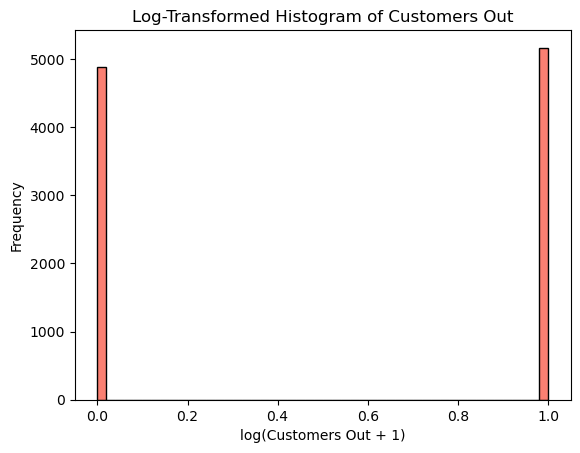

In [195]:
# mean_prediction = np.full_like(y_test, y_train.mean(), dtype=np.float64)
# null_rmse = mean_squared_error(y_test, mean_prediction, squared=False)
# print(f"Null RMSE: {null_rmse:.2f}")
#len(train)
plt.hist((y_test), bins=50, color='salmon', edgecolor='black')
plt.xlabel('log(Customers Out + 1)')
plt.ylabel('Frequency')
plt.title('Log-Transformed Histogram of Customers Out')
plt.show()
# y_train.describe()




In [113]:
# 1. Create RMSE scorer (since sklearn uses higher=better by default)
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# 2. Set up 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3. Initialize model
model = XGBRegressor(
    tree_method='hist',
    enable_categorical=True,
    random_state=42
)

# 4. Run CV and calculate scores
rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)

print("RMSEs from 5 folds:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))

mean_val = y.mean()
rmse_mean = np.sqrt(mean_squared_error(y, [mean_val] * len(y)))
print(f"Baseline RMSE (predicting mean): {rmse_mean:.2f}")

RMSEs from 5 folds: [172965.26987877 138072.18151535  67466.50230204  73473.5030186
 111165.70760643]
Mean RMSE: 112628.63286423779
Baseline RMSE (predicting mean): 275580.58


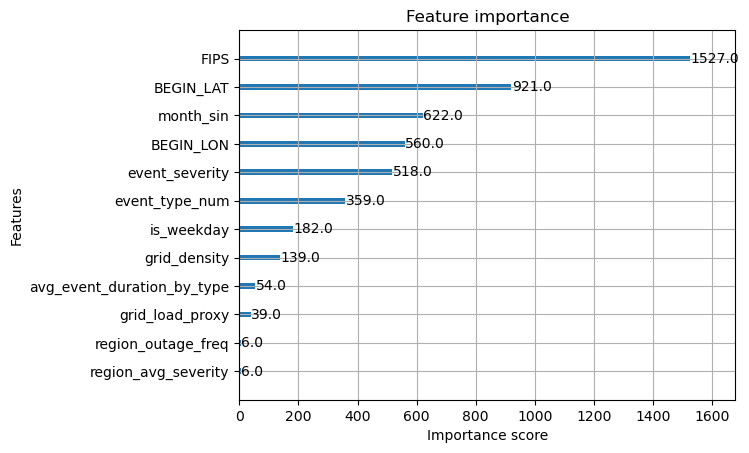

In [60]:
# fips_counts = X['FIPS'].value_counts()
# fips_with_multiple = fips_counts[fips_counts > 1]
# fips_with_multiple
# len(X)
#X['FIPS'].nunique()

# X['FIPS'].value_counts().sort_index().plot(kind='bar', figsize=(15, 4))
# plt.xlabel('FIPS Code')
# plt.ylabel('Number of Storms')
# plt.title('Storms per FIPS Code')
# plt.tight_layout()
# plt.show()

# X['FIPS'] = X['FIPS'].astype(str).str.zfill(5)

# # Filter for FIPS codes starting with '01'
# alabama_df = X[X['FIPS'].str.startswith('18')]

# # Plot
# alabama_df['FIPS'].value_counts().sort_index().plot(kind='bar', figsize=(12, 4))
# plt.xlabel('FIPS Code')
# plt.ylabel('Storm Count')
# plt.title('Storms in FIPS')
# plt.tight_layout()
# plt.show()
 
# y_mean = y.mean()
# rmse_mean = np.sqrt(((y - y_mean) ** 2).mean())
# rmse_mean

df.corr()['customers_out'].sort_values()
plot_importance(model)  # your trained XGBRegressor
plt.show()




FAILED RANDOM FOREST (DOESNT SUPPORT CATEGORICAL VARIABLES)

In [33]:
X = pd.get_dummies(df.drop(columns=['customers_out', 'outage_occurred']),
                   columns=['event_type_num', 'begin_weekday'])
y = df['outage_occurred']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2281  405]
 [ 231 4106]]
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      2686
           1       0.91      0.95      0.93      4337

    accuracy                           0.91      7023
   macro avg       0.91      0.90      0.90      7023
weighted avg       0.91      0.91      0.91      7023



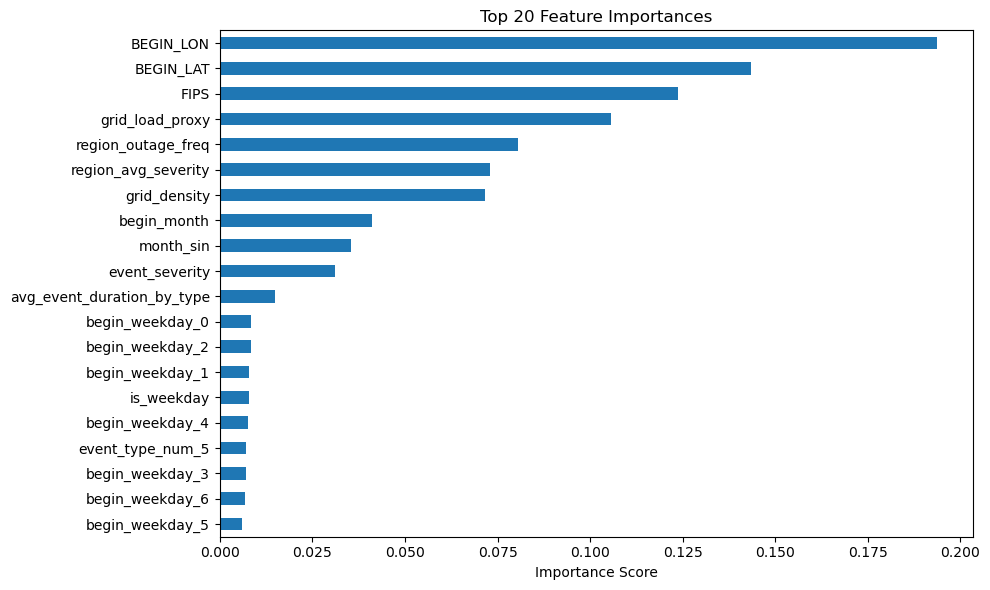

In [34]:
importances = model.feature_importances_
feature_names = X.columns

feature_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_series.head(20).plot(kind='barh')
plt.gca().invert_yaxis()  # top = most important
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [22]:
X_reg = X[df['outage_occurred'] == 1]
#y_reg = np.log1p(df.loc[df['outage_occurred'] == 1, 'customers_out'])
y_reg = (df.loc[df['outage_occurred'] == 1, 'customers_out'])

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(Xr_train, yr_train)

# Predict
yr_pred = regressor.predict(Xr_test)

# Evaluate
rmse = mean_squared_error(yr_test, yr_pred, squared=False)
r2 = r2_score(yr_test, yr_pred)

print("RMSE: ", rmse)
print("R2: ", r2)

RMSE:  89057.85411303409
R2:  0.6882755978715822


In [32]:
# mae = mean_absolute_error(yr_test, yr_pred)
# mae
# df.info()
print(df['event_type_num'].value_counts())


event_type_num
9     14400
5      9398
2      5063
3      2587
7      1518
10     1320
8       403
4       362
0        54
1        10
Name: count, dtype: int64
